In [1]:
%load_ext autoreload
%autoreload 2
# Add parent directory into system path
import sys, os
sys.path.insert(1, os.path.abspath(os.path.normpath('..')))

In [2]:
import torch
from torch import nn
from torch.nn.init import calculate_gain

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f'CUDA {i}: {torch.cuda.get_device_name(i)}')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
torch.set_default_dtype(torch.float32)

CUDA 0: NVIDIA GeForce GTX 1650 Ti


In [3]:
from models.MLP import Davies2021
#net = MLP(N_layers=8, width=32, loss_lambda=(1.0, 2.0, 0.0), activation=nn.Softplus(beta=1)).to(device)
#net = MLP(N_layers=8, width=32, activation=nn.Tanh(), init_gain=calculate_gain('tanh')).to(device)
net = Davies2021(N_layers=8, width=32).to(device)
#net = MLP_PINN(N_layers=8, width=32, loss_lambda=(1.0, 2.0, 0.0), activation=nn.ELU(), init_gain=1).to(device)

In [4]:
import os
from utils import RandomMeshSDFDataset

# Train from random calculated sdf
dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
train_dataset = RandomMeshSDFDataset(output_stl, sampling_method='importance', M=int(1e6), W=10, device=device)
print(train_dataset)

RandomMeshSDFDataset (10000 points)


In [5]:
import os
from utils import ImplicitDataset
# Train from random calculated sdf
dataset_name = '../datasets/box_1f0_gyroid_4pi'
output_stl = dataset_name+'.stl'
train_dataset = ImplicitDataset.from_file(dataset_name+'_train.npz', device=device, lazy_load=True)
print(train_dataset)

ImplicitDataset (20000 PDE points, 6025 Dirichlet BCs)


In [5]:
from utils.optimizer import CallbackScheduler

# Optimization
## ADA
optimizer=torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-6, amsgrad=False)
lr_scheduler = CallbackScheduler([
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.reduce_lr(0.2),
    CallbackScheduler.init_LBFGS(
        lr=1, max_iter=20, max_eval=40, 
        tolerance_grad=1e-5, tolerance_change=1e-9,
        history_size=100,
        line_search_fn=None
    ),
    CallbackScheduler.reduce_lr(0.2)
], optimizer=optimizer, model=net, eps=1e-7, patience=300)
# lr_scheduler = CallbackScheduler([
#     CallbackScheduler.reduce_lr(0.5),
#     CallbackScheduler.reduce_lr(0.5),
#     CallbackScheduler.reduce_lr(0.5)
# ], optimizer=optimizer, model=net, eps=1e-7, patience=300)

In [6]:
from torch.utils.data import DataLoader

max_epochs = 2500
PRINT_EVERY_EPOCH = 100
try:
    epoch = 0
    while epoch < max_epochs:
        #for bc in train_dataloader['bc']:
        # Training
        optimizer.zero_grad()
        loss = net.loss(train_dataset.points, train_dataset.sdfs)
        loss.backward()

        lr_scheduler.optimizer.step(lambda: loss)      
        lr_scheduler.step_when((epoch % 500) == 499)
        lr_scheduler.step_loss(loss)
        if epoch % PRINT_EVERY_EPOCH == 0:
            print(f'#{epoch} Loss: {net._loss:.6f}')

        epoch += 1
except KeyboardInterrupt as e:
    print('Bye bye')


#0 Loss: 0.034025
#100 Loss: 0.001857
#200 Loss: 0.000936
#300 Loss: 0.000773
#400 Loss: 0.000661
#500 Loss: 0.000568
#600 Loss: 0.000549
#700 Loss: 0.000532
#800 Loss: 0.000513
#900 Loss: 0.000493
#1000 Loss: 0.000473
#1100 Loss: 0.000469
#1200 Loss: 0.000464
#1300 Loss: 0.000455
#1400 Loss: 0.000272
#1500 Loss: 0.000192
#1600 Loss: 0.000164
#1700 Loss: 0.000144
#1800 Loss: 0.000128
#1900 Loss: 0.000115
#2000 Loss: 0.000104
#2100 Loss: 0.000096
#2200 Loss: 0.000089
#2300 Loss: 0.000081
#2400 Loss: 0.000075


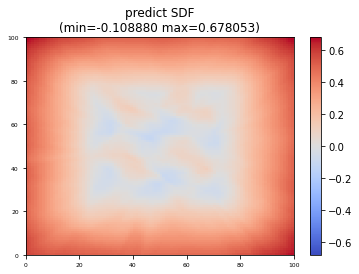

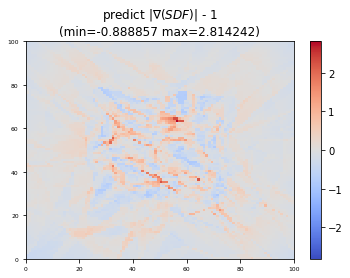

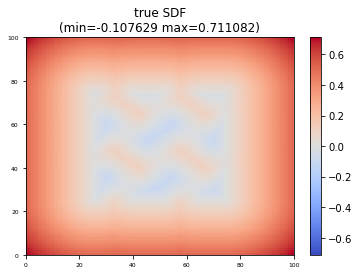

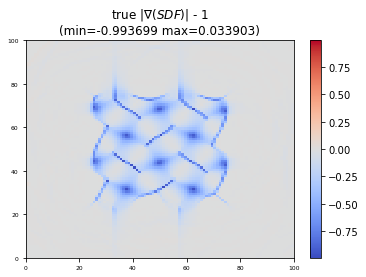

In [8]:
from utils import SDFVisualize
net.to(device)
visualize = SDFVisualize(z_level=0.3, step=0.05, offset=30, nums=100, device=device)
visualize.from_nn(net, bounds_from_mesh=output_stl)
visualize.from_mesh(output_stl)